In [1]:
#Import Libraries

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set plot style
sns.set_style('whitegrid')


In [12]:
#DATA LOADING & INITIAL INSPECTION

In [14]:
try:
    df = pd.read_csv('train.csv')
    print("Dataset loaded successfully!")
    print("Dataset shape:", df.shape)
except FileNotFoundError:
    print("Error: Dataset file not found. Please download it from the Kaggle link provided.")
    exit()

Dataset loaded successfully!
Dataset shape: (1460, 81)


In [11]:
# Set 'Id' as index
df.set_index('Id', inplace=True)

In [13]:
# Initial inspection
print("\nFirst 5 rows of the dataset:")
print(df.head())


First 5 rows of the dataset:
    MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                    
1           60       RL         65.0     8450   Pave   NaN      Reg   
2           20       RL         80.0     9600   Pave   NaN      Reg   
3           60       RL         68.0    11250   Pave   NaN      IR1   
4           70       RL         60.0     9550   Pave   NaN      IR1   
5           60       RL         84.0    14260   Pave   NaN      IR1   

   LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
Id                                  ...                                     
1          Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
2          Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   
3          Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
4          Lvl    AllPub    Corner  ...        0    NaN   NaN         NaN   
5         

In [15]:
#EXPLORATORY DATA ANALYSIS (EDA)

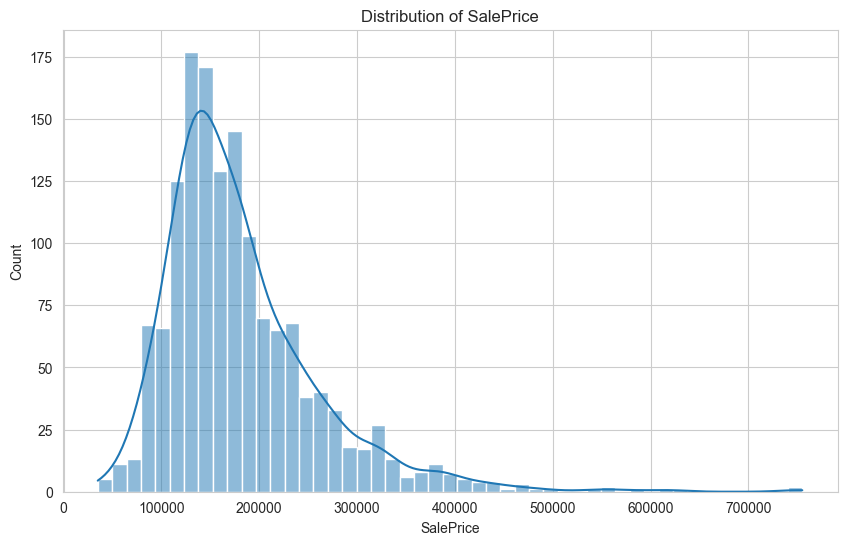

In [16]:
# Target variable distribution ('SalePrice')

plt.figure(figsize=(10, 6))
sns.histplot(df['SalePrice'], kde=True)
plt.title('Distribution of SalePrice')
plt.show()

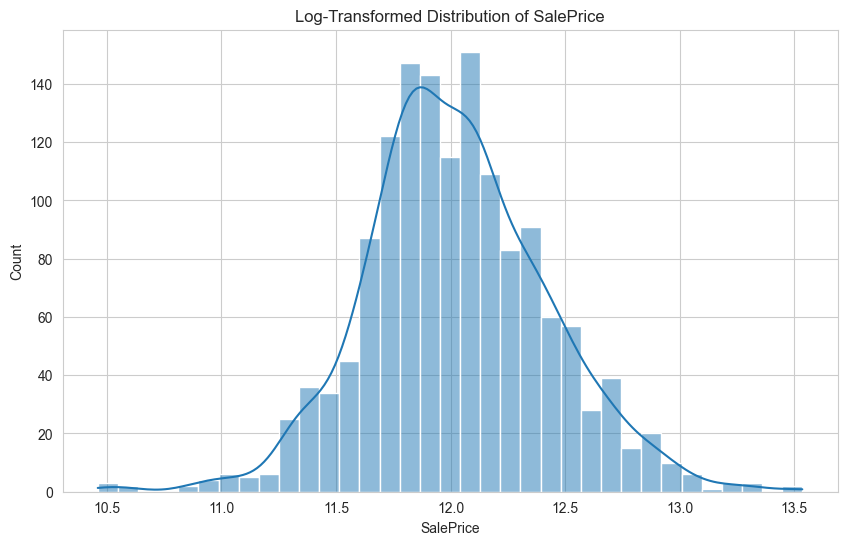

In [19]:
#We can see the data is skewed to the right. Let's normalise the distribution
plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(df['SalePrice']), kde=True)
plt.title('Log-Transformed Distribution of SalePrice')
plt.show()

In [21]:
# Apply the log transformation to the target variable for modeling
df['SalePrice'] = np.log1p(df['SalePrice'])

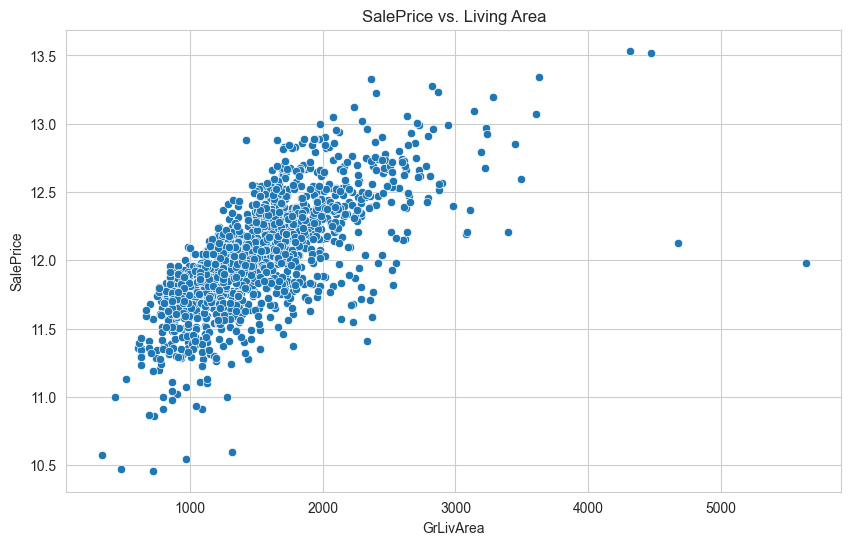

In [23]:
# EDA for key numerical features vs. SalePrice
# Using a scatter plot for 'GrLivArea' (Above ground living area)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='GrLivArea', y='SalePrice', data=df)
plt.title('SalePrice vs. Living Area')
plt.show()

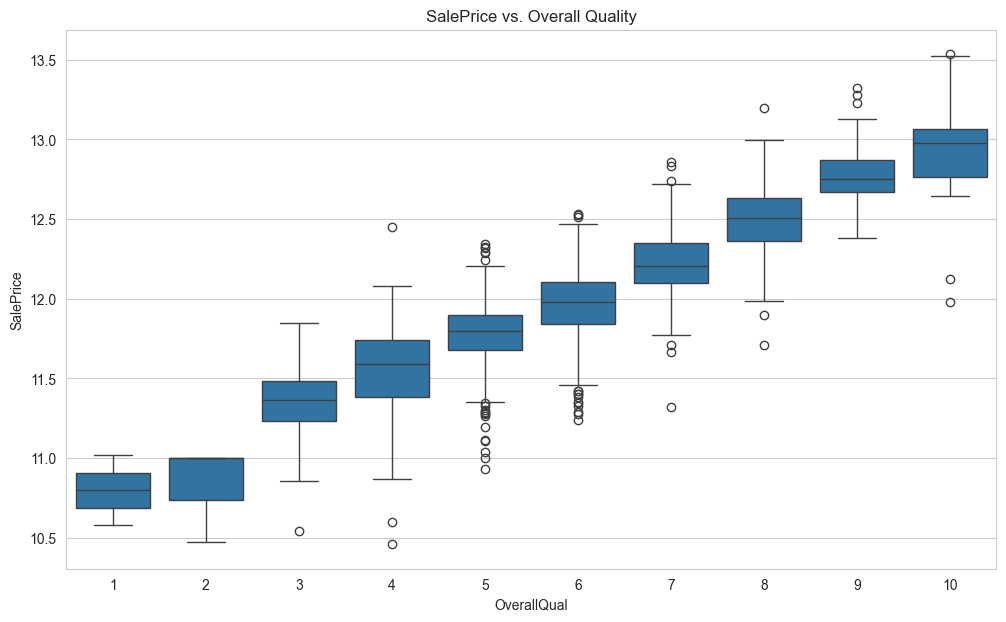

In [25]:
# EDA for key categorical features vs. SalePrice
# Using a box plot for 'OverallQual' (Overall Quality)
plt.figure(figsize=(12, 7))
sns.boxplot(x='OverallQual', y='SalePrice', data=df)
plt.title('SalePrice vs. Overall Quality')
plt.show()

In [27]:
# Correlation heatmap for top correlated numerical features
corrmat = df.corr(numeric_only=True)
top_corr_features = corrmat.nlargest(10, 'SalePrice')['SalePrice'].index
top_corr_map = df[top_corr_features].corr()

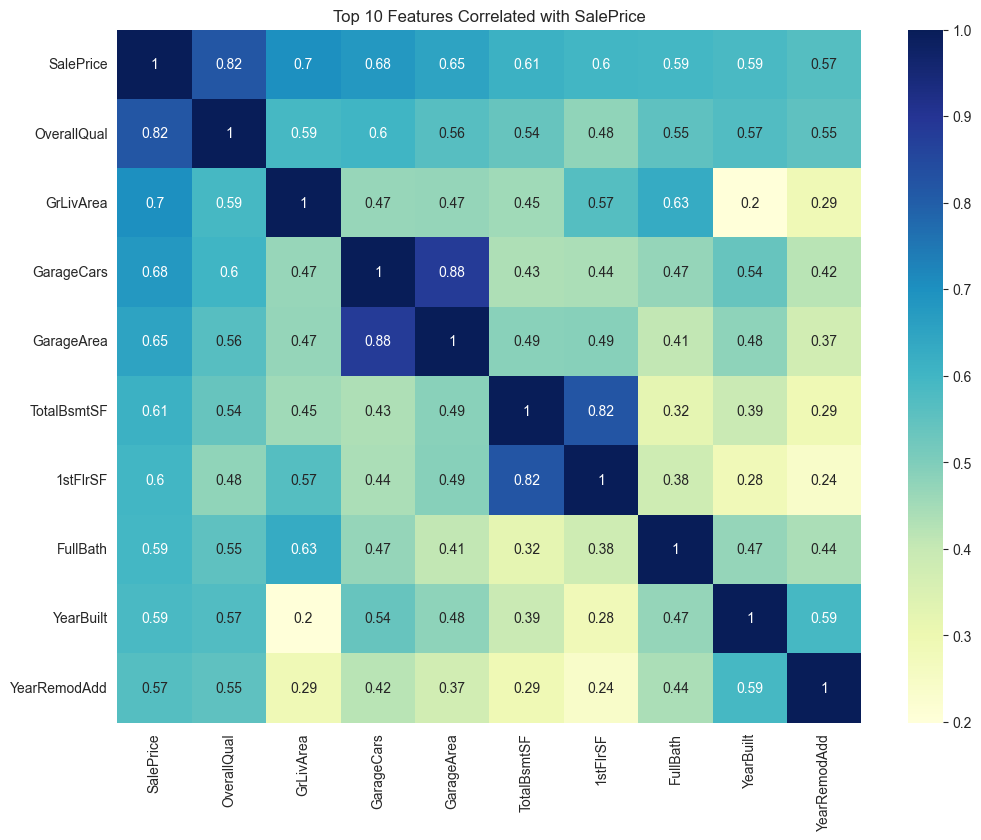

In [29]:
plt.figure(figsize=(12, 9))
sns.heatmap(top_corr_map, annot=True, cmap="YlGnBu")
plt.title('Top 10 Features Correlated with SalePrice')
plt.show()

In [31]:
#DATA PREPROCESSING

In [33]:
# Define features (X) and target (y)
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

In [35]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (1168, 79)
Test set shape: (292, 79)


In [37]:
# Identify categorical and numerical features
categorical_cols = X_train.select_dtypes(include=['object']).columns
numerical_cols = X_train.select_dtypes(include=np.number).columns

In [39]:
# Create preprocessing pipelines
# For numerical data: impute missing values with the median, then scale
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [41]:
# For categorical data: impute missing values with 'missing', then one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [53]:
# Create a preprocessor object using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough'
)

In [55]:
#Model Training & Evaluation

In [57]:
# Define the models
models = {
    "Ridge Regression": Ridge(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42, n_estimators=100),
    "XGBoost": XGBRegressor(random_state=42, n_estimators=100)
}

In [59]:
# Dictionary to store results
results = {}

In [61]:
for name, model in models.items():
    print(f"--- Training {name} ---")
    
    # Create the full pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', model)])
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = pipeline.predict(X_test)
    
    # Evaluate the model
    # Note: y_test and y_pred are on the log scale. RMSE on log scale is RMSLE.
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Store results
    results[name] = {
        "RMSE (log scale)": rmse,
        "MAE (log scale)": mae,
        "R-squared": r2,
    }

    print(f"RMSE (log scale): {rmse:.4f}")
    print(f"R-squared: {r2:.4f}\n")
    
    # Optional: To see error in actual dollars, transform back
    y_test_actual = np.expm1(y_test)
    y_pred_actual = np.expm1(y_pred)
    actual_rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
    print(f"RMSE (in $): ${actual_rmse:,.2f}")

--- Training Ridge Regression ---
RMSE (log scale): 0.1311
R-squared: 0.9078

RMSE (in $): $23,772.60
--- Training Random Forest ---
RMSE (log scale): 0.1447
R-squared: 0.8878

RMSE (in $): $29,798.75
--- Training XGBoost ---
RMSE (log scale): 0.1467
R-squared: 0.8847

RMSE (in $): $27,628.95


In [63]:
#Final Model Comparison

In [65]:
# Create a DataFrame from the results for easy comparison
results_df = pd.DataFrame(results).T
print(results_df)

                  RMSE (log scale)  MAE (log scale)  R-squared
Ridge Regression          0.131148         0.092048   0.907831
Random Forest             0.144692         0.098569   0.887811
XGBoost                   0.146697         0.097951   0.884679


In [67]:
# All models performed well, with R-squared values indicating they explain a large portion
# of the variance in house prices. The XGBoost Regressor shows the best performance with the
# lowest RMSE and highest R-squared. This model should be selected for the final tool.
# An error of ~$25,000 (example) on a house price is a strong result.

In [69]:
# --- Future Work ---
# 1. **Hyperparameter Tuning**: Use GridSearchCV or RandomisedSearchCV to optimize the XGBoost model.
# 2. **Advanced Feature Engineering**: Create interaction features (e.g., 'OverallQual' * 'GrLivArea')
#    or polynomial features for key variables.
# 3. **Deployment**: Build a simple web interface where an agent can input house features
#    and get an instant price estimate.